#### Importing required libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
from datetime import datetime
import itertools
import time
import holidays
import sklearn
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


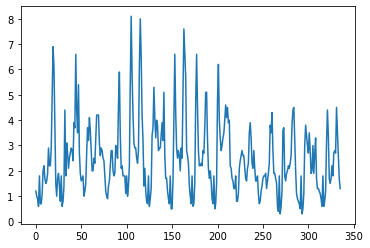

In [4]:
datac=pd.read_csv('/content/drive/MyDrive/Hackathons/BlueSky/CO.csv')
# Extracting CO data
CO_data=datac['CO(GT)']
#visualizing CO data
CO_data.plot()

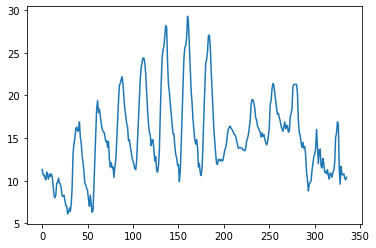

In [5]:
datat=pd.read_csv('/content/drive/MyDrive/Hackathons/BlueSky/T.csv')
# Extracting Temperature data
Temp_data=datat['T']
#visualizing Temperature data
Temp_data.plot()

#### Defining MAPE 

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

#### Data Pre-processing

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Hackathons/BlueSky/data.csv',sep=';')
df=df[['Date','Time','CO(GT)','T']]
df.Date=pd.to_datetime(df.Date, format='%d/%m/%Y')
df=df[(df.Date>='2004-03-11')&(df.Date<'2004-03-25')]
df["CO(GT)"] = [float(str(i).replace(",", ".")) for i in df["CO(GT)"]]
df["T"] = [float(str(i).replace(",", ".")) for i in df["T"]]
df.replace(-200.0, np.nan, inplace=True)
df.to_csv('/content/drive/MyDrive/Hackathons/BlueSky/data.csv',index=False)
df.head()

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Hackathons/BlueSky/data.csv')
df.head()

,Date,Time,CO(GT),T
0,2004-03-11,00.00.00,1.2,11.3
1,2004-03-11,01.00.00,1.0,10.7
2,2004-03-11,02.00.00,0.9,10.7
3,2004-03-11,03.00.00,0.6,10.3
4,2004-03-11,04.00.00,NaN,10.1


In [ ]:
df = df.fillna(-200.0)

In [ ]:
for i in range(len(df)):
  if df.iloc[i]['CO(GT)'] == -200.0:
    value_replace = (df.iloc[i-1]['CO(GT)'] + df.iloc[i+1]['CO(GT)'])/2
    df.loc[i, 'CO(GT)'] = value_replace

In [ ]:
df.head()

,Date,Time,CO(GT),T
0,2004-03-11,00.00.00,1.20,11.3
1,2004-03-11,01.00.00,1.00,10.7
2,2004-03-11,02.00.00,0.90,10.7
3,2004-03-11,03.00.00,0.60,10.3
4,2004-03-11,04.00.00,0.65,10.1


In [ ]:
# 
list_of_dates=[]
list_of_mapes_co=[]

## Using the SARIMAX Algorithm

#### Results for 18/03/2004

In [ ]:
date_of_begin = "2004-03-11"
data_of_end = "2004-03-17"

In [ ]:
#Training dataset
x_train=df[df['Date'] <= data_of_end]
CO_train = x_train['CO(GT)']

In [ ]:
#Testing dataset
date_of_test = "2004-03-18"
CO_test=df[df['Date'] <= date_of_test][['Date','Time','CO(GT)']].reset_index()

In [ ]:
#Training our model for CO
CO_model = SARIMAX(CO_train, order=(6,0,3), seasonal_order=(1,1,1,24), enforce_stationarity=False, enforce_invertibility=False).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
#Prediction by model
CO_predictions=CO_model.predict(0,CO_test.shape[0])
CO_test['Predicted CO']=CO_predictions

No handles with labels found to put in legend.


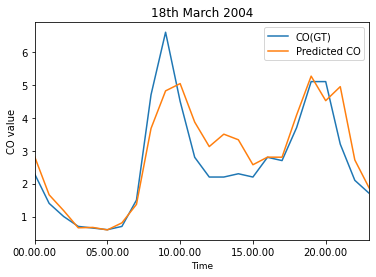

In [ ]:
ax = plt.gca()
ax.set_xlabel("Time",fontsize=9)
ax.set_ylabel("CO value",fontsize=10)
ax.set_title('18th March 2004',fontsize=12);
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
ax.tick_params(axis='both', which='minor', labelsize=6)
plt.legend(loc=2, prop={'size':10})
CO_test[CO_test['Date'] >=  date_of_test].plot(kind='line',x='Time',y=['CO(GT)'],ax=ax)
CO_test[CO_test['Date'] >= date_of_test].plot(kind='line',x='Time',y=['Predicted CO'],ax=ax)
plt.show()

In [ ]:
# Calculating MAPE
CO_mape_18=mean_absolute_percentage_error(CO_test[CO_test['Date']>=date_of_test]['CO(GT)'],CO_test[CO_test['Date']>=date_of_test]['Predicted CO'])
CO_mape_18

19.905196998541122

In [ ]:
list_of_dates.append(date_of_test)
list_of_mapes_co.append(CO_mape_18)

#### Results for 19/03/2004

In [ ]:
date_of_begin = "2004-03-11"
data_of_end = "2004-03-18"

In [ ]:
#Training dataset
x_train=df[df['Date'] <= data_of_end]
CO_train = x_train['CO(GT)']

In [ ]:
#Testing dataset
date_of_test = "2004-03-19"
CO_test=df[df['Date'] <= date_of_test][['Date','Time','CO(GT)']].reset_index()

In [ ]:
#Training our model for CO
CO_model = SARIMAX(CO_train, order=(4,0,1), seasonal_order=(2, 1, 0, 24), enforce_stationarity=False, enforce_invertibility=False).fit()

In [ ]:
#Prediction by model
CO_predictions=CO_model.predict(0,CO_test.shape[0])
CO_test['Predicted CO']=CO_predictions

No handles with labels found to put in legend.


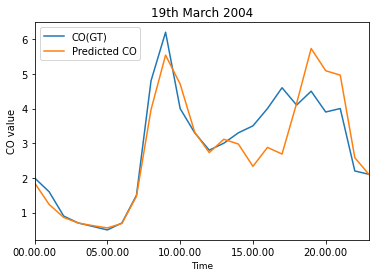

In [ ]:
ax = plt.gca()
ax.set_xlabel("Time",fontsize=9)
ax.set_ylabel("CO value",fontsize=10)
ax.set_title('19th March 2004',fontsize=12);
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
ax.tick_params(axis='both', which='minor', labelsize=6)
plt.legend(loc=2, prop={'size':10})
CO_test[CO_test['Date'] >=  date_of_test].plot(kind='line',x='Time',y=['CO(GT)'],ax=ax)
CO_test[CO_test['Date'] >= date_of_test].plot(kind='line',x='Time',y=['Predicted CO'],ax=ax)
plt.show()

In [ ]:
# Calculating MAPE
CO_mape_19=mean_absolute_percentage_error(CO_test[CO_test['Date']>=date_of_test]['CO(GT)'],CO_test[CO_test['Date']>=date_of_test]['Predicted CO'])
CO_mape_19

13.33943442497171

In [ ]:
list_of_dates.append(date_of_test)
list_of_mapes_co.append(CO_mape_19)

#### Results for 20/03/2004

In [ ]:
date_of_begin = "2004-03-11"
data_of_end = "2004-03-19"

In [ ]:
#Training dataset
x_train=df[df['Date'] <= data_of_end]
CO_train = x_train['CO(GT)']

In [ ]:
#Testing dataset
date_of_test = "2004-03-20"
CO_test=df[df['Date'] <= date_of_test][['Date','Time','CO(GT)']].reset_index()

In [ ]:
#Training our model for CO
CO_model = SARIMAX(CO_train, order=(4,0,1), seasonal_order=(1, 0, 0, 24), enforce_stationarity=False, enforce_invertibility=False).fit()

In [ ]:
#Prediction by model
CO_predictions=CO_model.predict(0,CO_test.shape[0])
CO_test['Predicted CO']=CO_predictions

No handles with labels found to put in legend.


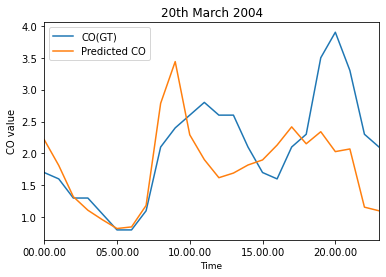

In [ ]:
ax = plt.gca()
ax.set_xlabel("Time",fontsize=9)
ax.set_ylabel("CO value",fontsize=10)
ax.set_title('20th March 2004',fontsize=12);
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
ax.tick_params(axis='both', which='minor', labelsize=6)
plt.legend(loc=2, prop={'size':10})
CO_test[CO_test['Date'] >=  date_of_test].plot(kind='line',x='Time',y=['CO(GT)'],ax=ax)
CO_test[CO_test['Date'] >= date_of_test].plot(kind='line',x='Time',y=['Predicted CO'],ax=ax)
plt.show()

In [ ]:
# Calculating MAPE
CO_mape_20=mean_absolute_percentage_error(CO_test[CO_test['Date']>=date_of_test]['CO(GT)'],CO_test[CO_test['Date']>=date_of_test]['Predicted CO'])
CO_mape_20

23.864296088379202

In [ ]:
list_of_dates.append(date_of_test)
list_of_mapes_co.append(CO_mape_20)

#### Results for 21/03/2004

In [ ]:
date_of_begin = "2004-03-11"
data_of_end = "2004-03-20"

In [ ]:
#Training dataset
x_train=df[df['Date'] <= data_of_end]
CO_train = x_train['CO(GT)']

In [ ]:
#Testing dataset
date_of_test = "2004-03-21"
CO_test=df[df['Date'] <= date_of_test][['Date','Time','CO(GT)']].reset_index()

In [ ]:
#Training our model for CO
CO_model = SARIMAX(CO_train, order=(6,0,0), seasonal_order=(1, 0, 0, 24), enforce_stationarity=False, enforce_invertibility=False).fit()

In [ ]:
#Prediction by model
CO_predictions=CO_model.predict(0,CO_test.shape[0])
CO_test['Predicted CO']=CO_predictions

No handles with labels found to put in legend.


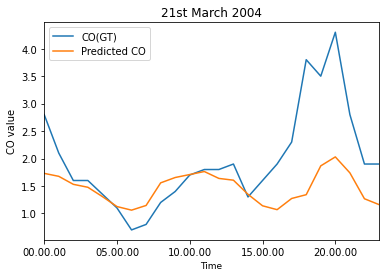

In [ ]:
ax = plt.gca()
ax.set_xlabel("Time",fontsize=9)
ax.set_ylabel("CO value",fontsize=10)
ax.set_title('21st March 2004',fontsize=12);
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
ax.tick_params(axis='both', which='minor', labelsize=6)
plt.legend(loc=2, prop={'size':10})
CO_test[CO_test['Date'] >=  date_of_test].plot(kind='line',x='Time',y=['CO(GT)'],ax=ax)
CO_test[CO_test['Date'] >= date_of_test].plot(kind='line',x='Time',y=['Predicted CO'],ax=ax)
plt.show()

In [ ]:
# Calculating MAPE
CO_mape_21=mean_absolute_percentage_error(CO_test[CO_test['Date']>=date_of_test]['CO(GT)'],CO_test[CO_test['Date']>=date_of_test]['Predicted CO'])
CO_mape_21

26.695206716618603

In [ ]:
list_of_dates.append(date_of_test)
list_of_mapes_co.append(CO_mape_21)

#### Results for 22/03/2004

In [ ]:
date_of_begin = "2004-03-11"
data_of_end = "2004-03-21"

In [ ]:
#Training dataset
x_train=df[df['Date'] <= data_of_end]
CO_train = x_train['CO(GT)']

In [ ]:
#Testing dataset
date_of_test = "2004-03-22"
CO_test=df[df['Date'] <= date_of_test][['Date','Time','CO(GT)']].reset_index()

In [ ]:
#Training our model for CO
CO_model = SARIMAX(CO_train, order=(6,0,5), seasonal_order=(4, 0, 0, 24), enforce_stationarity=False, enforce_invertibility=False).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
#Prediction by model
CO_predictions=CO_model.predict(0,CO_test.shape[0])
CO_test['Predicted CO']=CO_predictions

No handles with labels found to put in legend.


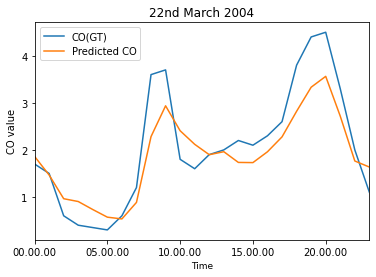

In [ ]:
ax = plt.gca()
ax.set_xlabel("Time",fontsize=9)
ax.set_ylabel("CO value",fontsize=10)
ax.set_title('22nd March 2004',fontsize=12);
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
ax.tick_params(axis='both', which='minor', labelsize=6)
plt.legend(loc=2, prop={'size':10})
CO_test[CO_test['Date'] >=  date_of_test].plot(kind='line',x='Time',y=['CO(GT)'],ax=ax)
CO_test[CO_test['Date'] >= date_of_test].plot(kind='line',x='Time',y=['Predicted CO'],ax=ax)
plt.show()

In [ ]:
# Calculating MAPE
CO_mape_22=mean_absolute_percentage_error(CO_test[CO_test['Date']>=date_of_test]['CO(GT)'],CO_test[CO_test['Date']>=date_of_test]['Predicted CO'])
CO_mape_22

32.31246579387347

In [ ]:
list_of_dates.append(date_of_test)
list_of_mapes_co.append(CO_mape_22)

#### Results for 23/03/2004

In [ ]:
date_of_begin = "2004-03-11"
data_of_end = "2004-03-22"

In [ ]:
#Training dataset
x_train=df[df['Date'] <= data_of_end]
CO_train = x_train['CO(GT)']

In [ ]:
#Testing dataset
date_of_test = "2004-03-23"
CO_test=df[df['Date'] <= date_of_test][['Date','Time','CO(GT)']].reset_index()

In [ ]:
#Training our model for CO
CO_model = SARIMAX(CO_train, order=(3,0,2), seasonal_order=(5, 0, 2, 24), enforce_stationarity=False, enforce_invertibility=False).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
#Prediction by model
CO_predictions=CO_model.predict(0,CO_test.shape[0])
CO_test['Predicted CO']=CO_predictions

No handles with labels found to put in legend.


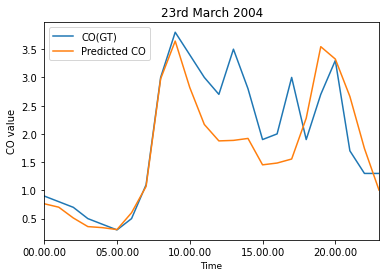

In [ ]:
ax = plt.gca()
ax.set_xlabel("Time",fontsize=9)
ax.set_ylabel("CO value",fontsize=10)
ax.set_title('23rd March 2004',fontsize=12);
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
ax.tick_params(axis='both', which='minor', labelsize=6)
plt.legend(loc=2, prop={'size':10})
CO_test[CO_test['Date'] >=  date_of_test].plot(kind='line',x='Time',y=['CO(GT)'],ax=ax)
CO_test[CO_test['Date'] >= date_of_test].plot(kind='line',x='Time',y=['Predicted CO'],ax=ax)
plt.show()

In [ ]:
# Calculating MAPE
CO_mape_23=mean_absolute_percentage_error(CO_test[CO_test['Date']>=date_of_test]['CO(GT)'],CO_test[CO_test['Date']>=date_of_test]['Predicted CO'])
CO_mape_23

22.648513521215428

In [ ]:
list_of_dates.append(date_of_test)
list_of_mapes_co.append(CO_mape_23)

#### Results for 24/03/2004

In [ ]:
date_of_begin = "2004-03-11"
data_of_end = "2004-03-23"

In [ ]:
#Training dataset
x_train=df[df['Date'] <= data_of_end]
CO_train = x_train['CO(GT)']

In [ ]:
#Testing dataset
date_of_test = "2004-03-24"
CO_test=df[df['Date'] <= date_of_test][['Date','Time','CO(GT)']].reset_index()

In [ ]:
#Training our model for CO
CO_model = SARIMAX(CO_train, order=(2,0,1), seasonal_order=(1, 0, 1, 24), enforce_stationarity=False, enforce_invertibility=False).fit()

In [ ]:
#Prediction by model
CO_predictions=CO_model.predict(0,CO_test.shape[0])
CO_test['Predicted CO']=CO_predictions

In [ ]:
ax = plt.gca()
ax.set_xlabel("Time",fontsize=9)
ax.set_ylabel("CO value",fontsize=10)
ax.set_title('24th March 2004',fontsize=12);
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
ax.tick_params(axis='both', which='minor', labelsize=6)
plt.legend(loc=2, prop={'size':10})
CO_test[CO_test['Date'] >=  date_of_test].plot(kind='line',x='Time',y=['CO(GT)'],ax=ax)
CO_test[CO_test['Date'] >= date_of_test].plot(kind='line',x='Time',y=['Predicted CO'],ax=ax)
plt.show()

No handles with labels found to put in legend.


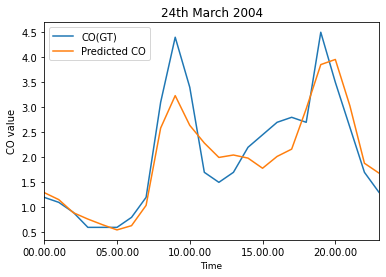

In [ ]:
ax = plt.gca()
ax.set_xlabel("Time",fontsize=9)
ax.set_ylabel("CO value",fontsize=10)
ax.set_title('24th March 2004',fontsize=12);
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
ax.tick_params(axis='both', which='minor', labelsize=6)
plt.legend(loc=2, prop={'size':10})
CO_test[CO_test['Date'] >=  date_of_test].plot(kind='line',x='Time',y=['CO(GT)'],ax=ax)
CO_test[CO_test['Date'] >= date_of_test].plot(kind='line',x='Time',y=['Predicted CO'],ax=ax)
plt.show()

In [ ]:
# Calculating MAPE
CO_mape_24=mean_absolute_percentage_error(CO_test[CO_test['Date']>=date_of_test]['CO(GT)'],CO_test[CO_test['Date']>=date_of_test]['Predicted CO'])
CO_mape_24

17.73069010375807

In [ ]:
list_of_dates.append(date_of_test)
list_of_mapes_co.append(CO_mape_24)

In [ ]:
df = pd.DataFrame(list(zip(list_of_dates, list_of_mapes_co)), columns =['Date', 'mape'])

In [ ]:
mean_value_of_mape_co=np.mean(df['mape'])
mean_value_of_mape_co

22.356543378193944